# Create .h5 file for training deepretina on both whitenoise and naturalscenes

In [52]:
import numpy as np
from sklearn.decomposition import PCA
import scipy.io
import itertools
import os
import h5py
import pyret.visualizations as pyviz
import pyret.filtertools as ft
import pyret.spiketools as st
import pyret.stimulustools as stimtools
import jetpack
from experiments.iotools import read_channel # from niru-analysis github
from experiments.photodiode import find_peaks, find_start_times
# import binary     # in igor >> recording
import pdb
import string
# from jetpack.signals import peakdet
from scipy.signal import find_peaks_cwt
from os.path import expanduser

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, xlabel, ylabel, title, imshow

# note that nonposx(y) for log plots will no longer work with this package
import mpld3
#mpld3.enable_notebook()

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load data

In [84]:
whitenoise_datafile = '/Users/lmcintosh/experiments/data/15-10-07/whitenoise.h5'
naturalscene_datafile = '/Users/lmcintosh/experiments/data/15-10-07/naturalscene.h5'
datafile = '/Users/lmcintosh/experiments/data/15-10-07/experiment.h5'

In [85]:
wn = h5py.File(whitenoise_datafile, 'r')
ns = h5py.File(naturalscene_datafile, 'r')
f = h5py.File(datafile, 'r')

In [4]:
list(f)

[u'cell01',
 u'cell02',
 u'cell03',
 u'cell04',
 u'cell05',
 u'cell06',
 u'cell07',
 u'cell08',
 u'cell09',
 u'expt1',
 u'expt10',
 u'expt11',
 u'expt12',
 u'expt13',
 u'expt14',
 u'expt15',
 u'expt16',
 u'expt17',
 u'expt18',
 u'expt19',
 u'expt2',
 u'expt20',
 u'expt21',
 u'expt22',
 u'expt23',
 u'expt24',
 u'expt3',
 u'expt4',
 u'expt5',
 u'expt6',
 u'expt7',
 u'expt8',
 u'expt9']

In [6]:
list(f['expt1'])

[u'start_time', u'stim', u'stop_time', u'timestamps']

# Store spike times

In [12]:
num_cells = 9
spikes = []
for c in range(num_cells):
    spikes.append(f['cell%02i' %(c+1)][:])

# Parse spikes and stim into train and test sets

In [113]:
total_trials = 24
num_repeats = 6
stim_types = 2

last_train_time = 0.0
last_test_time = 0.0

train_binned = []
train_spikes_5ms = []
train_spikes_10ms = []
train_spikes_20ms = []
train_stim = []
train_time = []

test_binned = []
test_spikes_5ms = []
test_spikes_10ms = []
test_spikes_20ms = []
test_stim = []
test_time = []

# we have to exclude expt24 because we couldn't get a start and stop time
for expt in range(total_trials-1):
    expt_name = 'expt%i' %(expt+1)
    expt_stim = np.array(f[expt_name + '/stim'])
    start = np.array(f[expt_name + '/start_time'])
    stop = np.array(f[expt_name + '/stop_time'])
    time = np.array(f[expt_name + '/timestamps'])
    
    # upsample stim
    stim = np.array(f[expt_name + '/stim'])
    stim_us, time_us = stimtools.upsample_stim(stim, 3, time=time) # upsample 30 hz stim by factor of 3
    
    binned = []
    rates_5ms = []
    rates_10ms = []
    rates_20ms = []
    for c in spikes:
        one_cell_spikes = [sp-start for sp in c if sp >= start and sp <= stop]
        bspk, tax = st.binspikes(one_cell_spikes, time=time_us)
        binned.append(bspk)
        rates_5ms.append(st.estfr(tax, bspk, sigma=0.005)) # 5 ms Gaussian
        rates_10ms.append(st.estfr(tax, bspk, sigma=0.01)) # 10 ms Gaussian
        rates_20ms.append(st.estfr(tax, bspk, sigma=0.02)) # 20 ms Gaussian
    
    expt_binned = np.vstack(binned)
    expt_rates_5ms = np.vstack(rates_5ms)
    expt_rates_10ms = np.vstack(rates_10ms)
    expt_rates_20ms = np.vstack(rates_20ms)

    # train data
    if expt % stim_types == 0:
        train_stim.append(stim_us[:-1, :, :])
        train_binned.append(expt_binned)
        train_spikes_5ms.append(expt_rates_5ms)
        train_spikes_10ms.append(expt_rates_10ms)
        train_spikes_20ms.append(expt_rates_20ms)
        train_time.append(time_us[:-1] + last_train_time)
        last_train_time = time_us[-1]
    # test data
    else:
        test_stim.append(stim_us[:-1, :, :])
        test_binned.append(expt_binned)
        test_spikes_5ms.append(expt_rates_5ms)
        test_spikes_10ms.append(expt_rates_10ms)
        test_spikes_20ms.append(expt_rates_20ms)
        test_time.append(time_us[:-1] + last_test_time)
        last_test_time = time_us[-1]

In [66]:
train_stim[0].shape

(59966, 50, 50)

In [114]:
train_spikes_10ms[0].shape

(9, 59966)

In [68]:
train_time[0].shape

(59966,)

In [72]:
test_stim[10].shape

(5996, 50, 50)

In [115]:
test_binned[10].shape

(9, 5996)

In [78]:
np.vstack(test_stim).shape

(65956, 50, 50)

In [116]:
np.hstack(test_spikes_5ms).shape

(9, 65956)

In [86]:
np.hstack(test_time).shape

(65956,)

# Concatenate the training data

In [117]:
all_train_stim = np.vstack(train_stim)
all_train_binned = np.hstack(train_binned)
all_train_spikes_5ms = np.hstack(train_spikes_5ms)
all_train_spikes_10ms = np.hstack(train_spikes_10ms)
all_train_spikes_20ms = np.hstack(train_spikes_20ms)
all_train_time = np.hstack(train_time)

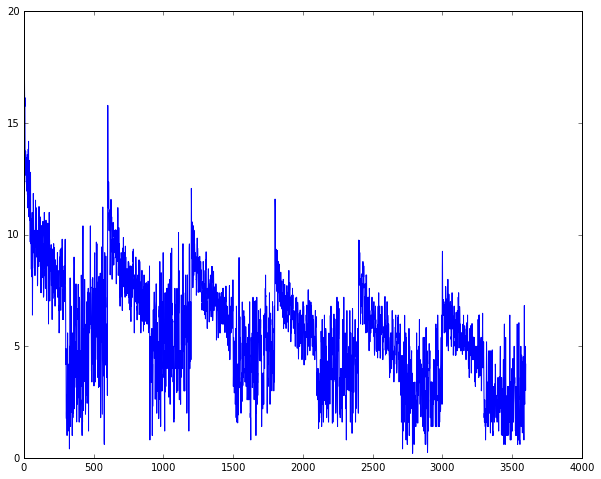

In [121]:
plt.plot(np.convolve(all_train_spikes_20ms[0, :], 0.002*np.ones((500,)), 'same')[::200])

# Concatenate the test data from the whitenoise and naturalscene h5 files

In [93]:
list(wn['test'])

[u'repeats', u'response', u'stimulus', u'time']

In [96]:
np.array(wn['test/response/firing_rate_10ms']).shape

(9, 5997)

In [124]:
all_test_stim = np.vstack([np.array(wn['test/stimulus']), np.array(ns['test/stimulus'])])
all_test_binned = np.hstack([np.array(wn['test/response/binned']), 
                                  np.array(ns['test/response/binned'])])
all_test_spikes_5ms = np.hstack([np.array(wn['test/response/firing_rate_5ms']), 
                                  np.array(ns['test/response/firing_rate_5ms'])])
all_test_spikes_10ms = np.hstack([np.array(wn['test/response/firing_rate_10ms']), 
                                  np.array(ns['test/response/firing_rate_10ms'])])
all_test_spikes_20ms = np.hstack([np.array(wn['test/response/firing_rate_20ms']), 
                                  np.array(ns['test/response/firing_rate_20ms'])])
all_test_time = np.hstack([np.array(wn['test/time']), np.array(ns['test/time'])])

In [125]:
all_test_stim.shape

(11994, 50, 50)

In [126]:
all_test_spikes_10ms.shape

(9, 11994)

# Save these to both.h5

In [130]:
h = h5py.File('/Users/lmcintosh/experiments/data/15-10-07/both.h5', 'w')


##### spikes #####
for idx in range(num_cells):
    h.create_dataset('spikes/cell%02d' %(idx+1), data=np.array(spikes[idx]))

##### train #####
h.create_dataset('train/stimulus', data=all_train_stim)
h.create_dataset('train/time', data=all_train_time)
h.create_dataset('train/response/binned', data=all_train_binned)
h.create_dataset('train/response/firing_rate_10ms', data=all_train_spikes_10ms)
h.create_dataset('train/response/firing_rate_20ms', data=all_train_spikes_20ms)
h.create_dataset('train/response/firing_rate_5ms', data=all_train_spikes_5ms)

##### test #####
h.create_dataset('test/stimulus', data=all_test_stim)
h.create_dataset('test/time', data=all_test_time)
h.create_dataset('test/response/binned', data=all_test_binned)
h.create_dataset('test/response/firing_rate_10ms', data=all_test_spikes_10ms)
h.create_dataset('test/response/firing_rate_20ms', data=all_test_spikes_20ms)
h.create_dataset('test/response/firing_rate_5ms', data=all_test_spikes_5ms)

h.close()